In [30]:
import torch
import pickle
import numpy as np
import mdtraj as md
import nglview as nv

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from itertools import combinations
from pathlib import Path

# Load trajectory

In [8]:
base_dir = "/home/shpark/prj-mlcv/lib/bioemu/opes/simulations/"
molecule = "cln025"
method = "tae"
simulation_date = "0818_151509"
seed = "0"

simulation_dir = Path(base_dir) / molecule / method / simulation_date
print(simulation_dir)

/home/shpark/prj-mlcv/lib/bioemu/opes/simulations/cln025/tae/0818_151509


In [10]:
simulation_traj = md.load_xtc(
    simulation_dir / f"{seed}.xtc",
	top=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule.upper()}/{molecule.upper()}_from_mae.pdb"
)
simulation_view = nv.show_mdtraj(simulation_traj)
simulation_view.add_representation("licorice", selection="protein")
simulation_view

NGLWidget(max_frame=200)

# Analysis

## TICA

In [16]:
tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule.upper()}/{molecule.upper()}_tica_model_switch_lag10.pkl"
with open(tica_model_path, 'rb') as f:
    tica_model = pickle.load(f)
print(tica_model)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [36]:
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(simulation_traj.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	simulation_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)

ca_pair_contacts_switch = (1 - np.power(ca_pair_contacts / 0.8, 6)) / (1 - np.power(ca_pair_contacts / 0.8, 12))
simulation_tica_coord = tica_model.transform(ca_pair_contacts_switch)
simulation_tica_x = simulation_tica_coord[:, 0]
simulation_tica_y = simulation_tica_coord[:, 1]
print(simulation_tica_x.shape)

(201,)


In [33]:
cad_full_path = "/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/cad-switch.pt"
cad_full = torch.load(cad_full_path)
print(cad_full.shape)

tica_coord = tica_model.transform(cad_full.numpy())

torch.Size([530000, 45])


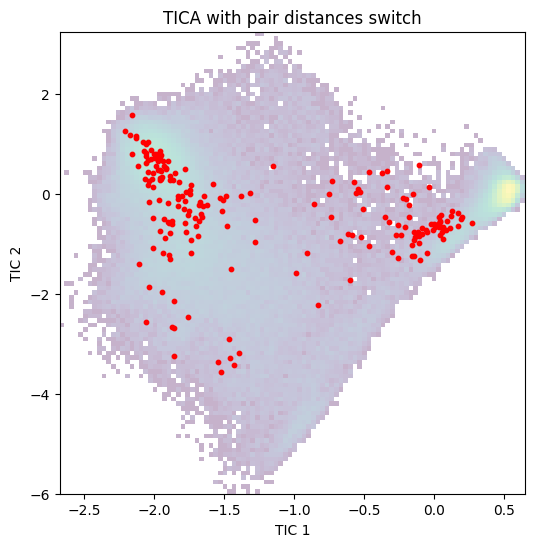

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(tica_coord[:, 0], tica_coord[:, 1], bins=100, norm=LogNorm(), alpha=0.3)
ax.scatter(simulation_tica_x, simulation_tica_y, c='red', s=10)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
plt.show()
plt.close()

## CV over time

In [48]:
# cad_full_path = "/home/shpark/prj-mlcv/lib/DESRES/dataset/CLN025-all/cad.pt"
# cad_full = torch.load(cad_full_path)

model = torch.jit.load("/home/shpark/prj-mlcv/lib/bioemu/model/_baseline_/tda-CLN025-jit.pt")
cv = model(torch.from_numpy(ca_pair_contacts))
print(cv.shape)

torch.Size([201, 1])


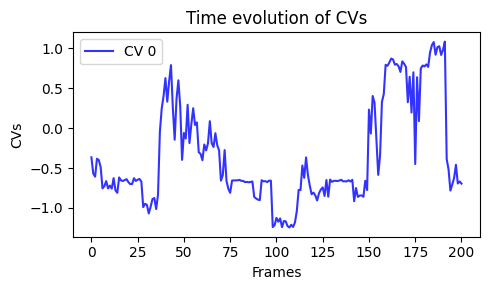

In [54]:
n_frames, n_cvs = cv.shape
time = range(n_frames)
cv_np = cv.detach().numpy()

plt.figure(figsize=(5, 3))
for i in range(n_cvs):
    plt.plot(time, cv_np[:, i], label=f"CV {i}", alpha=0.8, color = "blue")
plt.xlabel("Frames")
plt.ylabel("CVs")
plt.title("Time evolution of CVs")
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
reference_traj_path = "/home/shpark/prj-mlcv/lib/DESRES/data/CLN025/folded.pdb"
reference_traj = md.load_pdb(reference_traj_path)

ca_indices = simulation_traj.topology.select("name CA")
rmsd = md.rmsd(simulation_traj, reference_traj)
print(rmsd.shape)

(201,)


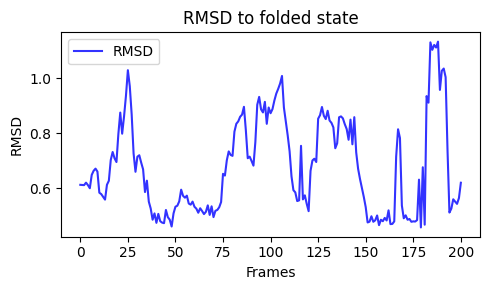

In [55]:
time = range(rmsd.shape[0])

plt.figure(figsize=(5, 3))
plt.plot(time, rmsd, label=f"RMSD", alpha=0.8, color = "blue")
plt.xlabel("Frames")
plt.ylabel("RMSD")
plt.title("RMSD to folded state")
plt.legend()
plt.tight_layout()
plt.show()

## asdf